In [1]:
from gptopt.optim.attn_kq import *
from gptopt.optim.linop import *
from utils import *

/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch

from gptopt.utils import set_seed
set_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Regularization of primal
$$
\begin{array}{ll}
{\text{minimize}} &  
\langle G_1, Z_1 \rangle + \langle G_2, Z_2 \rangle + \frac{\mu}{2}(\|Z_1\|_F^2 + \|Z_2\|_F^2)  + h(X) \\ 
\text{subject to} & X = Z_1^\top B + A^\top Z_2,
\end{array} 
$$

## PDHG
$$
\begin{aligned}
Y^{t+1} &= \operatorname{prox}_{\rho h^*}(Y^t + \rho 
((2Z_1^t - Z_1^{t-1})^\top B  + A^\top (2Z_2^t - Z_2^{t-1})))\\
\begin{bmatrix}
    Z_1^{t+1} \\ Z_2^{t+1}
\end{bmatrix} &=  \frac{1}{1 + \mu\gamma}\left (\begin{bmatrix}
    Z_1^t \\ Z_2^t
\end{bmatrix} - \gamma \left (
\begin{bmatrix}
    B(Y^{t+1})^\top \\ AY^{t+1}
\end{bmatrix}
+ \begin{bmatrix}
    G_1 \\ G_2
\end{bmatrix} \right ) \right )
\end{aligned}
$$




## FISTA for dual solve

$$
\begin{array}{ll}
{\text{maximize}} &  
-\frac{1}{2\mu}\|\mathcal{A}^*(Y) + G\|_F^2 - h^*(Y)
\end{array}  
$$
recover primal using
$$
Z = -\frac{1}{\mu}(\mathcal{A}^*(Y) + G)
$$

$$
\begin{aligned}
Y^{t+1} &= \mathbf{prox}_{\frac{1}{\alpha} h^*}\left (\tilde Y^t - \frac{1}{\alpha} \mathcal{A}(\mathcal{A}^*(\tilde Y^t) + G)\right )\\
\tilde Y^{t+1} &= Y^{t+1} + \frac{k-1}{k+2} ( Y^{t+1} -  Y^t)
\end{aligned}
$$

# Smooth relaxation of primal problem
$$
\begin{array}{ll}
{\text{minimize}} &  
\langle G, Z \rangle + \frac{1}{2\mu }\|(|\mathcal{A}(Z)| - \beta)_+\|_F^2
\end{array}  
$$

## Nesterov for primal problem
$$
\begin{align}
\nabla f(U^k) &= G + \frac{1}{\mu} \mathcal{A}^*\left (\mathcal{A}(U^k) 
- \Pi_{[-\beta, \beta]}(\mathcal{A}(U^k))\right ) \\
Z^{k+1} &= U^k - \frac{\mu}{{\|\mathcal{A}\|_{\operatorname{op}}^2}} \nabla f(U^k) \\
U^{k+1} &= Z^{k+1} + \frac{k-1}{k+2} (Z^{k+1} - Z^k)
\end{align}
$$

In [3]:
n_layer = 4
std1 = 1 #0.02 / np.sqrt(2.0 * n_layer)
std2 = 1 #0.01
rank_ratio = 0.7
max_iter = 100

mu_scales = [0.1, 0.001]
mu_moreau_scales = [1, 0.1, 0.001]
beta = 0.01

In [4]:
# Torch prox for h* (uses prox_l1 from pdhg.py)
prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
h_conj = lambda y: beta * torch.abs(y).sum()

#  $m=50, ~n=10, ~h=5$

In [5]:
n_head = 5
m = 50
n = 10

In [6]:
A2, A1, G1, G2 = gaussian_data_heads(m, n, n_head=n_head, std1=std1, std2=std2, 
                                            rank_ratio=rank_ratio, G_in_range=True, dtype=torch.float64)

beta = 0.05

A_linop = attn_linop_from_matrices_heads(A1, A2, n_head=n_head)
Grad = Z1_Z2_pack_Z_heads(G1, G2, n_head=n_head)
lamb_max = A_linop.fro_norm
mu_max = A_linop.mv(Grad).abs().max().item() / beta
mu_reg = mu_max * 0.01 

print(f"{lamb_max=:.4e}")

lamb_max=3.1858e+01


In [7]:
Z_star, f_star, Y_star = cvxpy_A_linop_heads(Grad.cpu().numpy(), A_linop, beta, n_head=n_head)
Z_star_torch = torch.tensor(Z_star, dtype=A1.dtype, device=device)
Y_star_torch = torch.tensor(Y_star, dtype=A1.dtype, device=device)

In [8]:
func_obj = lambda Z: (Grad * Z).sum().item()  
func_constr_viol = lambda Z: max(torch.max(torch.abs(A_linop.mv(Z))).item() - beta, 0) / beta

In [9]:
assert np.allclose(f_star, func_obj(Z_star_torch), rtol=1e-5)
print(
    f"{f_star=:.4e}" 
    f"\ncvxpy constraint violation: "
    f"{func_constr_viol(Z_star_torch)}"
)
print(pd_residuals_max_ball_linop(A_linop=A_linop, Y=Y_star_torch, 
                              Z=Z_star_torch, 
                              Grad=Grad, beta=beta, mu=0))

f_star=-2.4376e+00
cvxpy constraint violation: 1.916593148076906e-08
(1.985554638347091e-07, 1.7759340577536423e-07, 2.758640142125829e-14, 1.069083322873509e-15)


In [10]:
residuals = {}
for mu_scale in mu_scales:
    for mu_mor_scale in mu_moreau_scales:
        mu_reg = max(mu_scale * mu_max, 1e-6)
        print(f"{mu_reg=:.4e}, {mu_scale=:.4e}, {mu_mor_scale=:.4e}")
        mu_moreau = max(mu_mor_scale * mu_reg, 1e-6)
        residuals[(mu_scale, mu_mor_scale)], _ = compare_methods_fista_nesterov(A_linop, Grad, beta, mu_reg=mu_reg, 
                                mu_moreau=mu_moreau, func_obj=func_obj, func_constr_viol=func_constr_viol,
                                stopping=False, max_iter=max_iter)

mu_reg=7.0101e+01, mu_scale=1.0000e-01, mu_mor_scale=1.0000e+00
Method                 Obj          Viol
----------------------------------------
fista         -2.378184e+00  8.292391e-04
nesterov G init  -4.838116e+02  4.256519e+02
nesterov rand init  -4.838116e+02  4.256521e+02
nesterov zero init  -4.838116e+02  4.256518e+02
mu_reg=7.0101e+01, mu_scale=1.0000e-01, mu_mor_scale=1.0000e-01
Method                 Obj          Viol
----------------------------------------
fista         -2.378184e+00  8.292391e-04
nesterov G init  -5.057548e+01  4.256519e+01
nesterov rand init  -5.057551e+01  4.256521e+01
nesterov zero init  -5.057550e+01  4.256510e+01
mu_reg=7.0101e+01, mu_scale=1.0000e-01, mu_mor_scale=1.0000e-03
Method                 Obj          Viol
----------------------------------------
fista         -2.378184e+00  8.292391e-04
nesterov G init  -2.917339e+00  4.343001e-01
nesterov rand init  -2.917971e+00  4.201724e-01
nesterov zero init  -2.917065e+00  4.355358e-01
mu_reg=7.0101

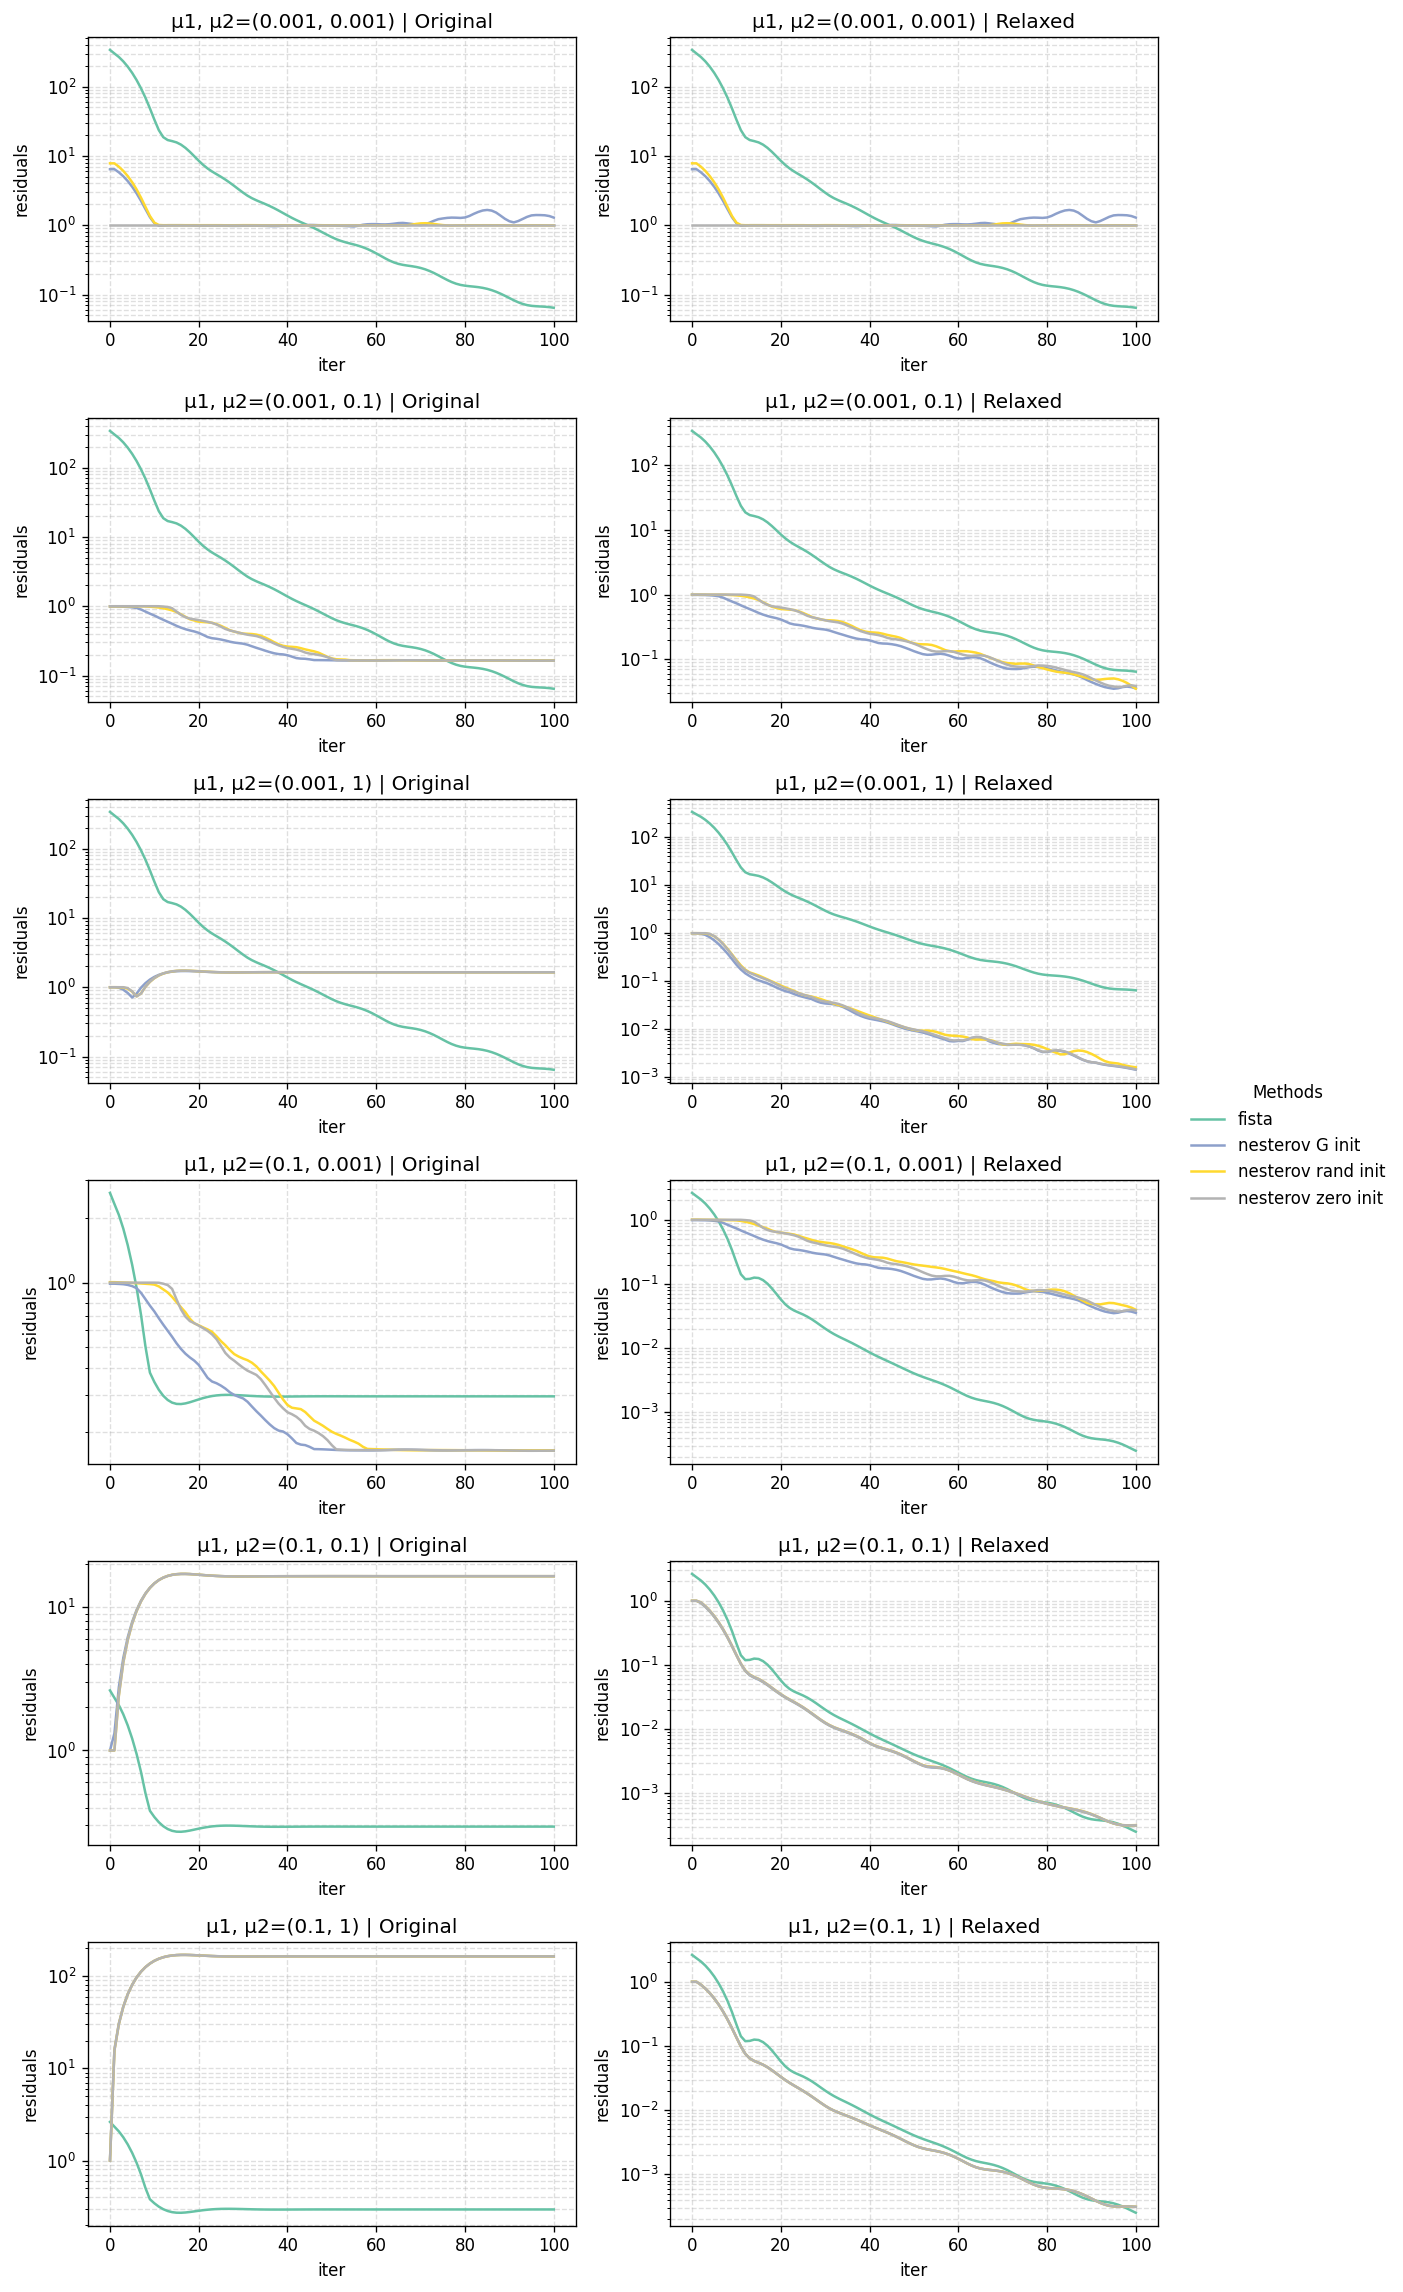

In [11]:
_ = plot_residuals_grid_by_param_appprox_vs_true(residuals)

#  $m=768, ~n=64, ~h=12$

In [12]:
m = 768
n_head = 12
n = 64 * n_head

In [13]:
std1 = 1
std2 = 1
beta = 0.05

A2, A1, G1, G2 = gaussian_data_heads(m, n, n_head=n_head, std1=std1, std2=std2, 
                                            rank_ratio=rank_ratio, G_in_range=True)

A_linop = attn_linop_from_matrices_heads(A1, A2, n_head=n_head)
Grad = Z1_Z2_pack_Z_heads(G1, G2, n_head=n_head)
mu_max = (A_linop.matvec(Grad)).abs().max().item() / beta
mu_reg = max(mu_scale * mu_max, 1e-6)
lamb_max = A_linop.fro_norm

print(f"{lamb_max=:.4e}")

lamb_max=1.0873e+03


In [14]:
residuals = {}
for mu_scale in mu_scales:
    for mu_mor_scale in mu_moreau_scales:
        mu_reg = max(mu_scale * mu_max, 1e-6)
        print(f"{mu_reg=:.4e}, {mu_scale=:.4e}, {mu_mor_scale=:.4e}")
        mu_moreau = max(mu_mor_scale * mu_reg, 1e-6)
        residuals[(mu_scale, mu_mor_scale)], _ = compare_methods_fista_nesterov(A_linop, Grad, beta, mu_reg=mu_reg, mu_moreau=mu_moreau,
                                
                                stopping=False, max_iter=max_iter)

mu_reg=3.1047e+01, mu_scale=1.0000e-01, mu_mor_scale=1.0000e+00
Method                 Obj          Viol
----------------------------------------
fista         -3.656676e+02  7.954537e-01
nesterov G init  -7.930222e+02  4.870960e+00
nesterov rand init  -7.679785e+02  5.032522e+00
nesterov zero init  -7.723618e+02  5.015735e+00
mu_reg=3.1047e+01, mu_scale=1.0000e-01, mu_mor_scale=1.0000e-01
Method                 Obj          Viol
----------------------------------------
fista         -3.656676e+02  7.954537e-01
nesterov G init  -2.101072e+02  6.017982e-01
nesterov rand init  -9.959883e+01  4.476195e-01
nesterov zero init  -9.963495e+01  7.000545e-02
mu_reg=3.1047e+01, mu_scale=1.0000e-01, mu_mor_scale=1.0000e-03
Method                 Obj          Viol
----------------------------------------
fista         -3.656676e+02  7.954537e-01
nesterov G init  -1.126929e+02  1.662293e-02
nesterov rand init  -1.000892e+00  9.897068e-03
nesterov zero init  -9.963496e-01  0.000000e+00
mu_reg=3.1047

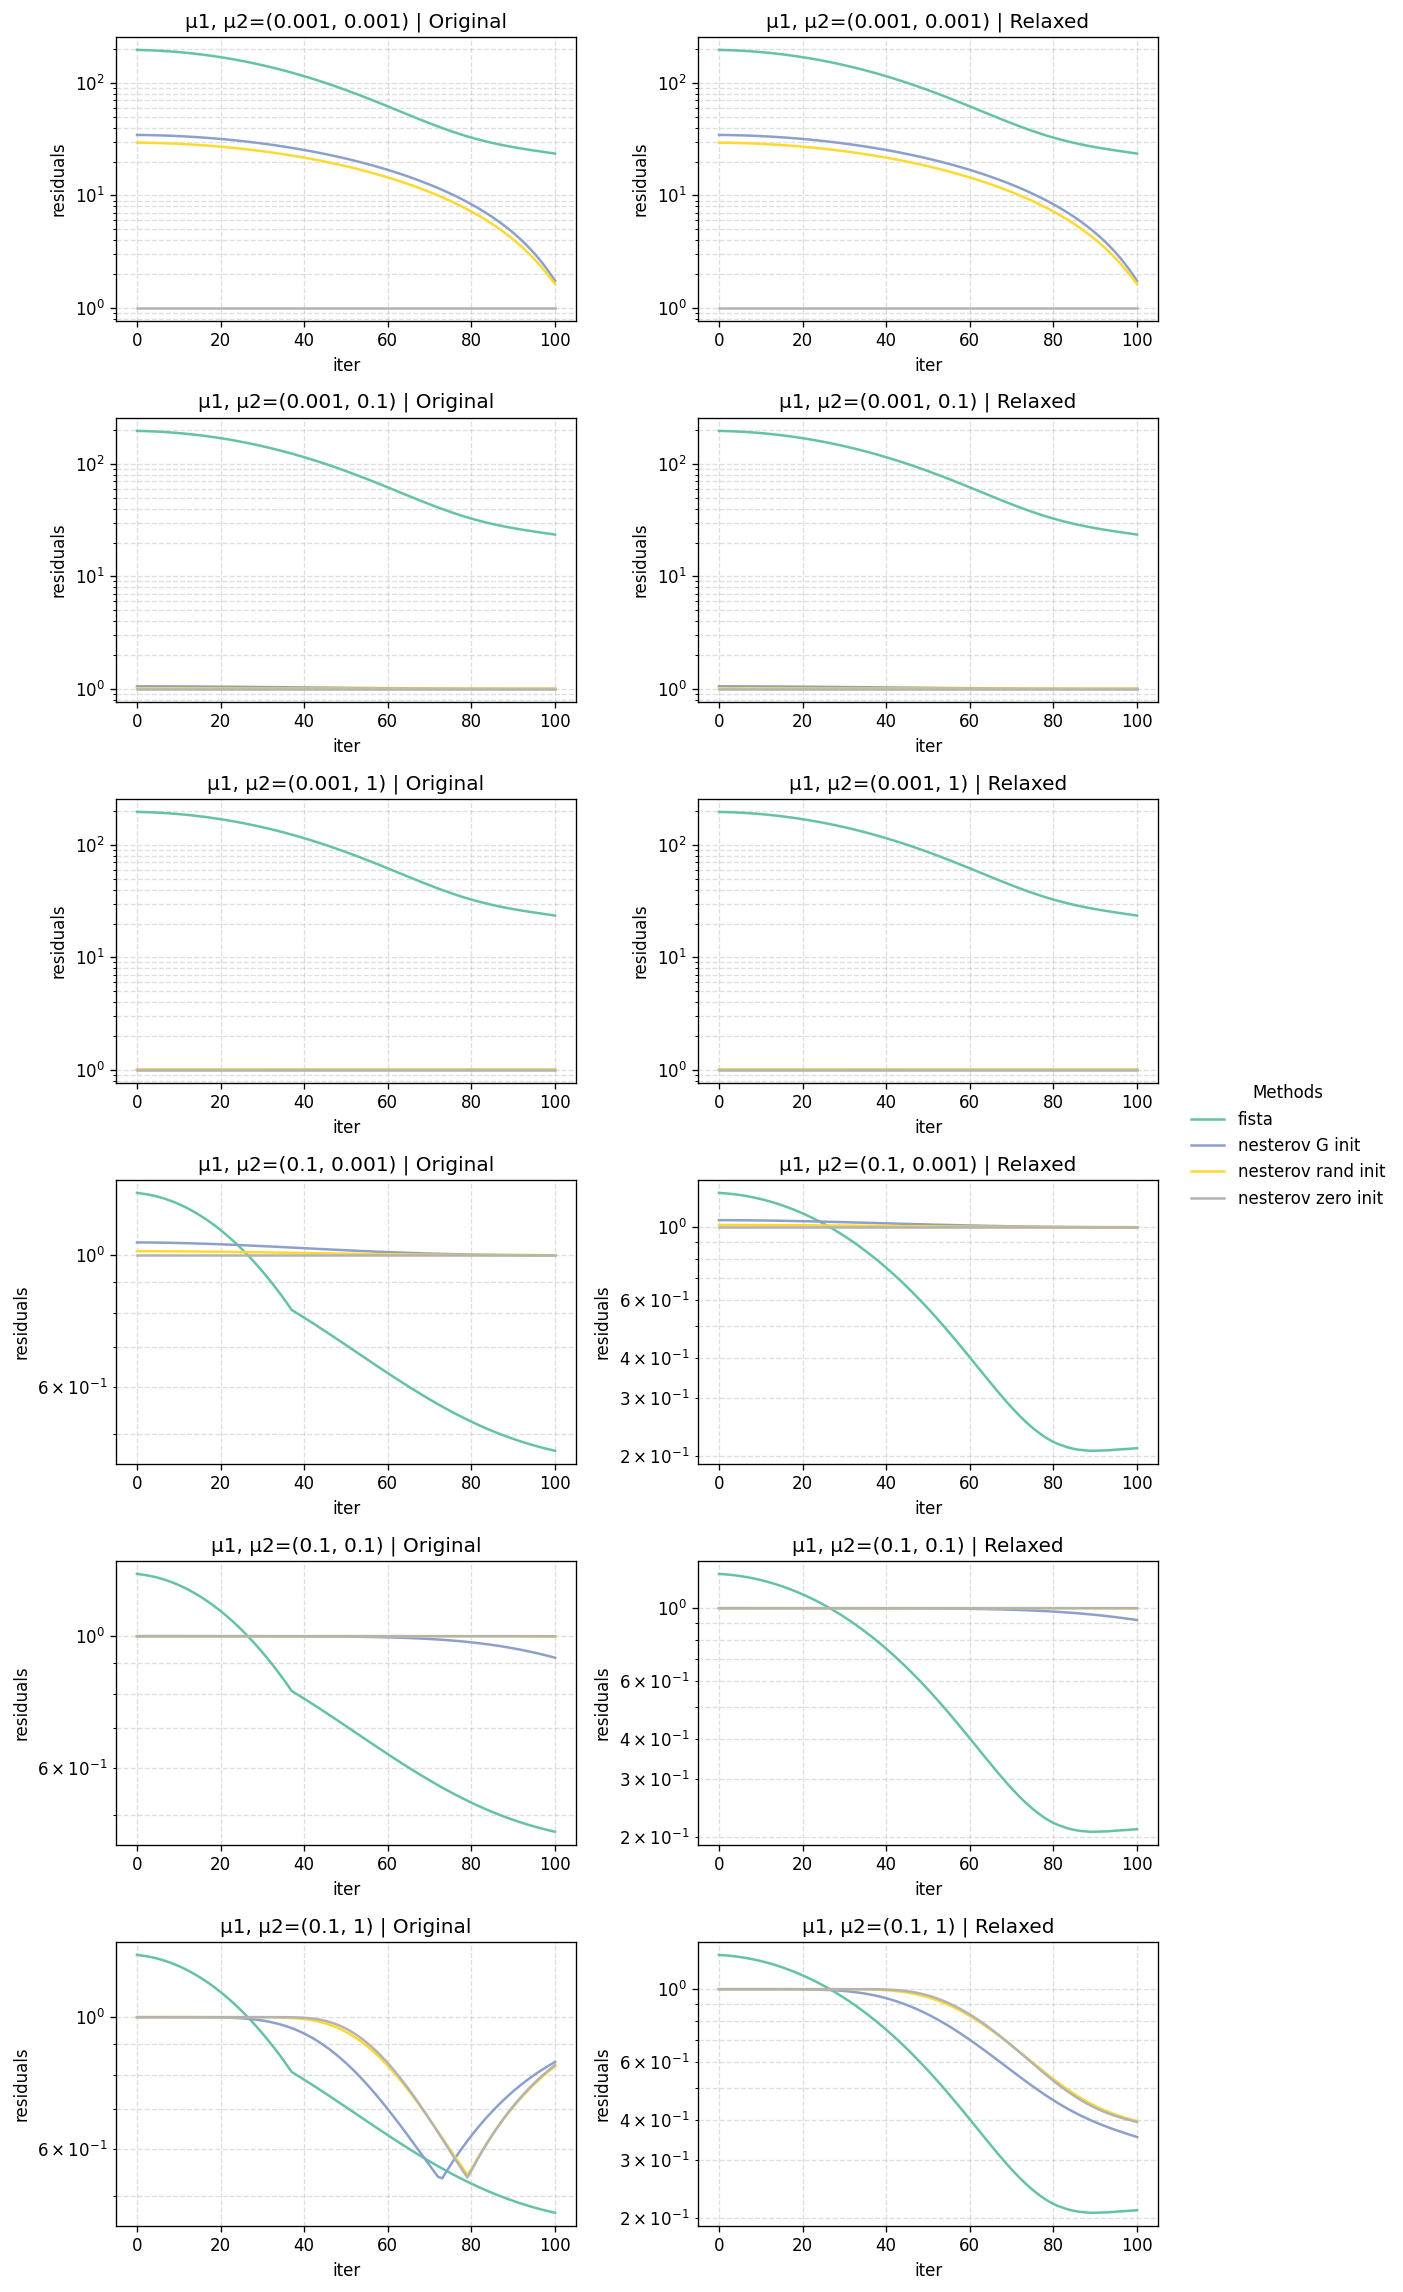

In [15]:
_ = plot_residuals_grid_by_param_appprox_vs_true(residuals)